In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [4]:
df = pd.read_csv('D:/Understanding PyTorch/Tabular Data Classification/dataset/riceClassification.csv')
df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [5]:
df.shape

(18185, 12)

In [6]:
df.dropna(inplace=True)

In [7]:
df.drop(['id'], axis=1, inplace = True)

In [8]:
df.shape

(18185, 11)

In [9]:
print(df['Class'].unique())

[1 0]


In [10]:
print(df['Class'].value_counts())

Class
1    9985
0    8200
Name: count, dtype: int64


In [11]:
original_df = df.copy()

In [12]:
# normalizing the data by the dividing the each column with its max value

for column in df.columns:
    df[column] = df[column] / df[column].max()

In [13]:
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [14]:
X = np.array(df.iloc[:, :-1])  # All columns except the last one (features)
y = np.array(df.iloc[:, -1])   # Last column (target)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [17]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(12729, 10)
(2728, 10)
(2728, 10)


In [18]:
class dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).to(device)


    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]


In [19]:
train_data = dataset(X_train, y_train)
val_data = dataset(X_val, y_val)
test_data = dataset(X_test, y_test)

In [20]:
train_dataloader = DataLoader(
    train_data,
    batch_size = 32,
    shuffle = True
)

val_dataloader = DataLoader(
    val_data,
    batch_size = 32,
    shuffle = True
)

test_dataloader = DataLoader(
    test_data,
    batch_size = 32,
    shuffle = True
)

In [21]:
HIDDEN_NEURONS = 10

class myModel(nn.Module):
    def __init__(self):
        super(myModel, self).__init__()

        self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
        self.linear = nn.Linear(HIDDEN_NEURONS, 1)
        self.activation = nn.Sigmoid()


    def forward(self, x):
        x = self.input_layer(x)
        x = self.linear(x)
        x = self.activation(x)

        return x

model = myModel().to(device)

In [22]:
summary(model, (X.shape[1], ))

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 10]                  110
├─Linear: 1-2                            [-1, 1]                   11
├─Sigmoid: 1-3                           [-1, 1]                   --
Total params: 121
Trainable params: 121
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 10]                  110
├─Linear: 1-2                            [-1, 1]                   11
├─Sigmoid: 1-3                           [-1, 1]                   --
Total params: 121
Trainable params: 121
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [23]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.03)

In [24]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_accuracy_train_plot = []
total_accuracy_validation_plot = []

EPOCH = 10

# looping through each batch
for epoch in range(EPOCH):
    # training
    total_acc_train = 0
    total_acc_validation = 0
    total_loss_train = 0
    total_loss_validation = 0
    
    for data in train_dataloader:
        inputs, labels = data

        prediction = model(inputs).squeeze(1)
        batch_loss = criterion(prediction, labels)
        total_loss_train += batch_loss.item()
        
        accuracy = ((prediction).round() == labels).sum().item()
        total_acc_train += accuracy

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # validation
    with torch.no_grad():
        for data in val_dataloader:
            inputs, labels = data

            prediction = model(inputs).squeeze(1)
            batch_loss = criterion(prediction, labels)
            total_loss_validation += batch_loss.item()

            accuracy = ((prediction).round() == labels).sum().item()
            total_acc_validation += accuracy
    
    # calculate the loss and accuracy
    total_loss_train_plot.append(round(total_loss_train / 1000, 4))
    total_loss_validation_plot.append(round(total_loss_validation / 1000, 4))

    total_accuracy_train_plot.append(round(total_acc_train / train_data.__len__() * 100, 4))
    total_accuracy_validation_plot.append(round(total_acc_validation / val_data.__len__() * 100, 4))

    print(f'''Epoch no. {epoch + 1} 
              Train Loss: {total_loss_train/1000:.4f} 
              Train Accuracy: {(total_acc_train/(train_data.__len__())*100):.4f} 
              Validation Loss: {total_loss_validation/1000:.4f} 
              Validation Accuracy: {(total_acc_validation/(val_data.__len__())*100):.4f}''')
              
    print("="*50)


Epoch no. 1 
              Train Loss: 0.0385 
              Train Accuracy: 96.7240 
              Validation Loss: 0.0040 
              Validation Accuracy: 98.2771
Epoch no. 2 
              Train Loss: 0.0213 
              Train Accuracy: 98.0753 
              Validation Loss: 0.0038 
              Validation Accuracy: 98.6437
Epoch no. 3 
              Train Loss: 0.0212 
              Train Accuracy: 98.1774 
              Validation Loss: 0.0037 
              Validation Accuracy: 98.6437
Epoch no. 4 
              Train Loss: 0.0213 
              Train Accuracy: 98.1538 
              Validation Loss: 0.0037 
              Validation Accuracy: 98.6437
Epoch no. 5 
              Train Loss: 0.0191 
              Train Accuracy: 98.3109 
              Validation Loss: 0.0038 
              Validation Accuracy: 98.6437
Epoch no. 6 
              Train Loss: 0.0200 
              Train Accuracy: 98.3188 
              Validation Loss: 0.0043 
              Validation Accuracy: 

In [25]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for data in test_dataloader:
    inputs, labels = data

    prediction = model(inputs).squeeze(1)

    batch_loss_test = criterion((prediction), labels)
    total_loss_test += batch_loss_test.item()
    acc = ((prediction).round() == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/X_test.shape[0])*100, 2)}%")

Accuracy Score is: 99.12%


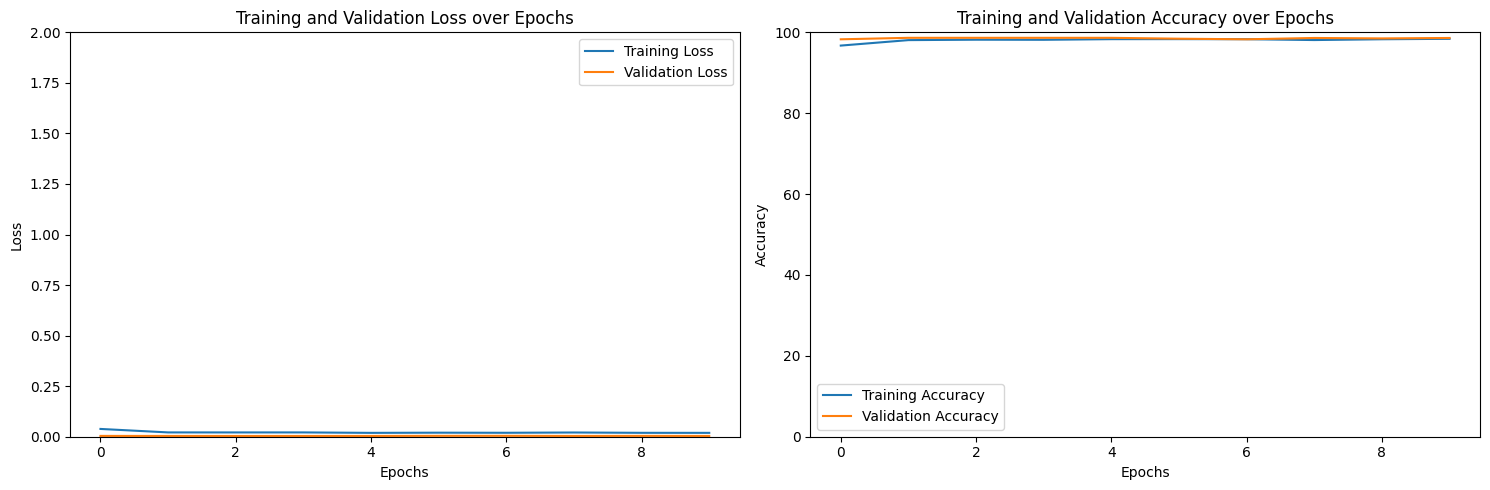

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_accuracy_train_plot, label='Training Accuracy')
axs[1].plot(total_accuracy_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()

In [27]:
torch.save(model.state_dict(), 'rice_type_classification.pth')